In [1]:
#Imports
import json
import numpy as np
import pandas as pd
import csv
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [14]:
path = 'C:/Users/Leand/OneDrive/Documentos/Lean/Analizador_imagenes_calcio/Luis/analisis/'
# path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Luis/analisis/'
experiments = os.listdir(path + 'jsons/')
min_exp = pd.DataFrame()
for i in range(0,len (experiments)):
    experiment = experiments[i]
    with open(path + 'jsons/' + experiment) as f:
        min_file = json.load(f)['image']['min_peaks_intensities']
        min_exp[i] = experiment,(np.array(min_file)*100/min_file[0]).std()
min_exp = pd.DataFrame (min_exp.T)
min_exp.columns = ['file','std_min']

C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
C:\Users\Leand\PyMOL\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [15]:
# Filtrado por tratamiento y frecuencia

def tau_filter(tratamiento,frecuencia,df):
    tabulado_filter = tabulado[(tabulado['tratamiento']==tratamiento) & (tabulado['frecuencia']== frecuencia)].reset_index(drop=True)
    tau = pd.DataFrame(columns = ['file','std_min'])
    for j in range(0,len (tabulado_filter)):
        celula = tabulado_filter['célula'][j]
        foto = tabulado_filter['foto'][j][:-4]
        for i in range(0,len (df)):
            if (celula in df['file'][i]) & (foto in df['file'][i]):
                tau.loc[j] = df.loc[i]
    return tau

In [16]:
tabulado = pd.read_csv(path + 'tabulado')
del tabulado['Unnamed: 0']

In [49]:
tabulado_control5 = tau_filter('C', 5, min_exp)
tabulado_vk5 = tau_filter('VK', 5, min_exp)
tabulado_dan5 = tau_filter('DAN', 5, min_exp)

In [50]:
tabulado_control5.drop(3, inplace=True)

In [51]:
def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    idx = ~((column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR)))
    return idx

In [52]:
tabulado_control5 = tabulado_control5[outliers(tabulado_control5['std_min'])]
tabulado_vk5 = tabulado_vk5[outliers(tabulado_vk5['std_min'])]
tabulado_dan5 = tabulado_dan5[outliers(tabulado_dan5['std_min'])]

C:\Users\Leand\PyMOL\lib\site-packages\seaborn\categorical.py:1326: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Leand\PyMOL\lib\site-packages\seaborn\categorical.py:1330: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


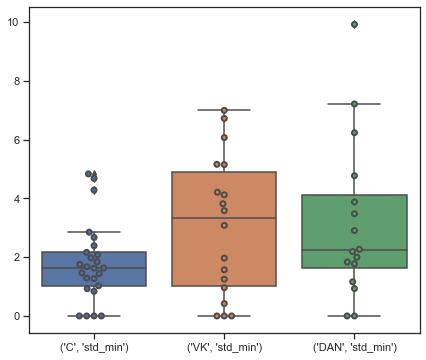

In [57]:
df = pd.concat ([tabulado_control5,tabulado_vk5,tabulado_dan5], axis=1, sort=False, keys=['C', 'VK','DAN'])
df
sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))


sns.boxplot(data=df)

sns.swarmplot(data=df, linewidth=2)
f.savefig("std_min%.png")

In [84]:
df.to_excel('std_min%.xlsx', engine = 'xlsxwriter')

In [59]:
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.kstest(tabulado_control5['std_min'],tabulado_vk5['std_min']))
print(scipy.stats.kstest(tabulado_vk5['std_min'],tabulado_dan5['std_min']))
print(scipy.stats.shapiro(tabulado_control5['std_min']))

KstestResult(statistic=0.35, pvalue=0.14071253883858315)
KstestResult(statistic=0.43555555555555553, pvalue=0.02485148697234585)
KstestResult(statistic=0.1875, pvalue=0.8718312783722354)
ShapiroResult(statistic=0.9040514230728149, pvalue=0.022501647472381592)


In [69]:
DI_control = pd.read_csv(path + 'DI_control.csv')

In [79]:
DI_control

,file,Discordance 1Hz,DISCORDANCE 5 Hz,min5
0,220119,0.13,0.34,[4.285714285714285]
1,170719c1,0.09,0.02,[1.632215440207518]
2,170719c5,0.17,0.28,[0.9279890199178028]
3,010819c1,0.26,0.35,[1.974181422830594]
7,230819c2,0.08,0.06,[1.6255328303139034]
8,031019c1,0.12,0.59,[2.390360209265152]
10,171019c1,0.12,0.13,[0.0]
11,171019c6,0.05,0.15,[2.0823765785947788]
12,311019c1,0.08,0.11,[2.6724760717824156]
13,311019c6,0.01,0.54,[2.165063509461097]


In [70]:
min5 = []
for i in range(0,len(DI_control['file'])):
    cel = DI_control['file'][i]
    filtro_wc5 = tabulado_control5[(tabulado_control5['file'].str.contains(cel) == True)]
    min5.append (filtro_wc5['std_min'].values)
DI_control['min5'] = min5

In [75]:
DI_control.drop(4, inplace=True)
DI_control.drop(5, inplace=True)
DI_control.drop(6, inplace=True)
DI_control.drop(9, inplace=True)
DI_control.drop(21, inplace=True)
b = [j for i in DI_control['min5'].tolist() for j in i]
a = DI_control['DISCORDANCE 5 Hz']

In [77]:
from scipy.stats.stats import pearsonr 
print (pearsonr(DI_control['DISCORDANCE 5 Hz'],b))

(0.22661431232143014, 0.3817672570257249)


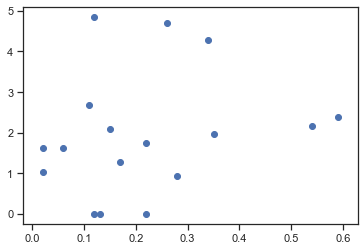

In [78]:
plt.scatter(a,b)

In [26]:
tabulado_control5

,file,std_min
0,010719ctrol1_analysis_result_ctrol1b0.json,2.851191
1,010719ctrol8_analysis_result_ctrol8a0.json,1.677852
2,010819c3_analysis_result_c3b001.json,5.804488
4,010819c1_analysis_result_c1b000.json,1.974181
5,010819c2_analysis_result_c2b000.json,16.881436
6,031019c4_analysis_result_c4e000.json,1.842569
7,031019c1_analysis_result_c1e000.json,2.390360
8,050320c1_analysis_result_c1d000.json,4.834918
9,050320c7_analysis_result_7d001.json,0.000000
10,050320c2_analysis_result_2d000.json,1.753157
